# Notebook to Reproduce Originality Detection Findings

## Start Testground

```
$ testground daemon
```

## Run Testplans in Docker:
``` 
$ testground run single --plan=coopbc --testcase=bc --runner=local:docker --builder=docker:go --instances=10 --collect
```

### Run Testplans in K8S:
```
$ testground run single --plan=coopbc --testcase=bc --runner=cluster:k8s --builder=docker:go --instances=10 --collect --build-cfg go_proxy_mode=direct
```

# Parsing Outputs

### Find Output Dirs

In [122]:
import os

docker_data_dir = "../outputs/aws_k8s/"
directory_contents = os.listdir(docker_data_dir)
print(directory_contents)

['c711uf8odceo9nj56hl0', 'c712fl0odceo9nj56i0g', 'c7114r8odceo9nj56h40', 'c711gu0odceo9nj56hc0', 'c710f9oodceo9nj56glg', 'c710p7godceo9nj56gs0', 'c710qloodceo9nj56gt0', 'c715jggodceujlqb06u0', 'c7126ugodceo9nj56hqg', 'c710kcgodceo9nj56gp0', 'c71556oodceosru3qqsg', 'c71293oodceo9nj56hs0', 'c712j9oodceo9nj56i30', 'c7143doodceosru3qqh0', 'c711acoodceo9nj56h7g', 'c712etoodceo9nj56i00', 'c711e0oodceo9nj56ha0', 'c7147moodceosru3qqig', 'c71187godceo9nj56h60', 'c7118ugodceo9nj56h6g', 'c71h6nktgkdg711j84qg', 'c711d9godceo9nj56h9g', 'c710u9oodceo9nj56gvg', 'c7116a0odceo9nj56h50', 'c712gc8odceo9nj56i10', 'c71091godceo9nj56ghg', 'c7112l8odceo9nj56h2g', 'c7127lgodceo9nj56hr0', 'c7110f8odceo9nj56h10', 'c715au0odceosru3qqug', 'c711vtoodceo9nj56hm0', 'c71gre4tgkdg711j84l0', 'c712e6godceo9nj56hvg', 'c710dr8odceo9nj56gkg', 'c71gvc4tgkdg711j84n0', 'c714690odceosru3qqi0', 'c710a0godceo9nj56gi0', 'c712hr0odceo9nj56i20', 'c710go8odceo9nj56gmg', 'c71gh4ktgkdg711j84g0', 'c7113cgodceo9nj56h30', 'c714200odceosr

### Find all .out files and map them to their RUNID

In [123]:
import os
import pathlib
from pathlib import Path
import glob

def listdir_r(dirpath):
    paths=[]
    paths.append(dirpath)
    for path in os.listdir(dirpath):
        rpath = os.path.join(dirpath, path)
        if os.path.isdir(rpath):
            subdirs = listdir_r(rpath)
            if not subdirs == []:
                paths.extend(subdirs)
    return paths

all_paths_dict = {}
for d in directory_contents:
    # print(docker_data_dir + d)
    all_paths = listdir_r(os.path.abspath(docker_data_dir + d))
    all_paths_containing_target = [s for s in all_paths if d in s]
    all_paths_dict[d]=all_paths_containing_target

# print(all_paths_dict)

### Find target JSON Outputs in .out files 

In [124]:
def check_dir_for_target_lines(search_path):
    search_str = "___UploaderData___"
    file_type = ".out"
    target_line = []
    result = []
    targets = 13 # MAGIC NUMBER for the number of outputs - i should have parsed the whole file as json and just check the exact message instead of all strings
    success = False
    for fname in os.listdir(path=search_path):
        if fname.endswith(file_type):
                fo = open(search_path + "/" + fname)
                line = fo.readline()
                line_no = 1
                while line != '' :
                        index = line.find(search_str)
                        if ( index != -1) :
                            # print(fname, "[", line_no, ",", index, "] ", line, sep="")
                            success = True
                        line = fo.readline()
                        if success == True and targets > 0:
                            result.append(line)
                            targets -= 1
                        line_no += 1
                fo.close()
    return result

output_lines_dict_by_runid = {}
for d in directory_contents:
    output = []
    output_lines = []
    paths_containing_target = all_paths_dict[d]
    for pct in paths_containing_target:
        output = check_dir_for_target_lines(pct)
        if output:
            for l in output:
                # print(l)
                output_lines.append(l)
    output_lines_dict_by_runid[d]=output_lines

# print(output_lines_dict_by_runid)

### Parse Json Results to Data Frame

In [125]:
import json
import pandas as pd

#d = {'Instances': [], 'Latency': [], 'Bandwidth': [], 'Jitter': [], 'Loss': [], 'Corrupt': [], 'S2CheckDuration': [], 'OriginalityRatio': [], 'OriginalCombinations': [], 'DhtUploadDuration': [], 'DhtQueryDuration': []}


uber_data = [{}]
for runid in output_lines_dict_by_runid:
    kvs_dict = {}
    kvs_dict["RunID"] = runid
    for o in output_lines_dict_by_runid[runid]:
        m = json.loads(o)["event"]["message_event"]["message"]
        kv = m.split(": ", 1)
        if len(kv) > 1:
            # Minute catcher
            kvm = kv[1].split("m",1)
            if len(kvm) > 1:
                kv[1]=float(kvm[1]) + float(kvm[0])*60
            # ms fix
            if float(kv[1]) > 100 and (kv[0] == "S2CheckDuration_s" or kv[0] == "DhtUploadDuration_s" or kv[0] == "DhtQueryDuration_ms"):
                kv[1]=float(kv[1])/1000
                #print(kv[1])
 
            kvs_dict[kv[0]] = float(kv[1])
    uber_data.append(kvs_dict)
uber_data.pop(0)
# print(uber_data)

my_data_frame = pd.DataFrame.from_dict(uber_data)
my_data_frame

,RunID,Instances,SimLatency_ms,SimPeerBandwidth_bps,SimJitter_ms,SimLoss_pct,SimCorrupt_pct,S2CheckDuration_s,OriginalityRatio_RO,UploadedOriginalCombinations,DhtUploadDuration_s,DhtQueryDuration_ms
0,c711uf8odceo9nj56hl0,60.0,10.0,1048576.0,0.0,0.0,0.0,6.074287,0.7,14.0,10.860324,0.879679
1,c712fl0odceo9nj56i0g,75.0,10.0,1048576.0,0.0,0.0,0.0,7.438921,0.7,14.0,12.829001,0.858792
2,c7114r8odceo9nj56h40,90.0,10.0,1048576.0,0.0,0.0,0.0,6.563676,0.7,14.0,12.567831,0.805121
3,c711gu0odceo9nj56hc0,70.0,10.0,1048576.0,0.0,0.0,0.0,6.138820,0.7,14.0,11.033969,0.708950
4,c710f9oodceo9nj56glg,45.0,10.0,1048576.0,0.0,0.0,0.0,9.038971,0.7,14.0,13.373204,0.619884
...,...,...,...,...,...,...,...,...,...,...,...,...
154,c711eo0odceo9nj56hag,55.0,10.0,1048576.0,0.0,0.0,0.0,7.209876,0.7,14.0,11.626850,0.783672
155,c71gpf4tgkdg711j84k0,30.0,80.0,1048576.0,20.0,1.0,1.0,8.395431,0.7,14.0,19.880457,2.585323
156,c71gofktgkdg711j84jg,20.0,80.0,1048576.0,20.0,1.0,1.0,12.291911,0.7,14.0,25.557776,3.520083
157,c71halktgkdg711j84sg,100.0,80.0,1048576.0,20.0,1.0,1.0,7.332128,0.7,14.0,19.616044,2.230631


### S2 Check Duration

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# my_data_frame.Instances=pd.to_numeric(my_data_frame.Instances)
# my_data_frame.S2CheckDuration_s=pd.to_numeric(my_data_frame.S2CheckDuration_s)
# my_data_frame.DhtUploadDuration_s=pd.to_numeric(my_data_frame.DhtUploadDuration_s)
# my_data_frame.DhtQueryDuration_ms=pd.to_numeric(my_data_frame.DhtQueryDuration_ms)
my_data_frame['DhtPutDuration_s'] = my_data_frame['DhtUploadDuration_s'] - my_data_frame['S2CheckDuration_s']

my_data_frame.SimLatency_ms=pd.to_numeric(my_data_frame.SimLatency_ms)
my_data_frame.SimJitter_ms=pd.to_numeric(my_data_frame.SimJitter_ms)
my_data_frame.SimPeerBandwidth_bps=pd.to_numeric(my_data_frame.SimPeerBandwidth_bps)
my_data_frame.SimLoss_pct=pd.to_numeric(my_data_frame.SimLoss_pct)
my_data_frame.SimCorrupt_pct=pd.to_numeric(my_data_frame.SimCorrupt_pct)

my_data_frame.sort_values(by=['Instances'], axis=0,ascending=True)
my_data_frame.info()
my_data_frame



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RunID                         159 non-null    object 
 1   Instances                     144 non-null    float64
 2   SimLatency_ms                 144 non-null    float64
 3   SimPeerBandwidth_bps          144 non-null    float64
 4   SimJitter_ms                  144 non-null    float64
 5   SimLoss_pct                   144 non-null    float64
 6   SimCorrupt_pct                144 non-null    float64
 7   S2CheckDuration_s             144 non-null    float64
 8   OriginalityRatio_RO           144 non-null    float64
 9   UploadedOriginalCombinations  144 non-null    float64
 10  DhtUploadDuration_s           144 non-null    float64
 11  DhtQueryDuration_ms           144 non-null    float64
 12  DhtPutDuration_s              144 non-null    float64
dtypes: fl

,RunID,Instances,SimLatency_ms,SimPeerBandwidth_bps,SimJitter_ms,SimLoss_pct,SimCorrupt_pct,S2CheckDuration_s,OriginalityRatio_RO,UploadedOriginalCombinations,DhtUploadDuration_s,DhtQueryDuration_ms,DhtPutDuration_s
0,c711uf8odceo9nj56hl0,60.0,10.0,1048576.0,0.0,0.0,0.0,6.074287,0.7,14.0,10.860324,0.879679,4.786037
1,c712fl0odceo9nj56i0g,75.0,10.0,1048576.0,0.0,0.0,0.0,7.438921,0.7,14.0,12.829001,0.858792,5.390080
2,c7114r8odceo9nj56h40,90.0,10.0,1048576.0,0.0,0.0,0.0,6.563676,0.7,14.0,12.567831,0.805121,6.004155
3,c711gu0odceo9nj56hc0,70.0,10.0,1048576.0,0.0,0.0,0.0,6.138820,0.7,14.0,11.033969,0.708950,4.895149
4,c710f9oodceo9nj56glg,45.0,10.0,1048576.0,0.0,0.0,0.0,9.038971,0.7,14.0,13.373204,0.619884,4.334232
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,c711eo0odceo9nj56hag,55.0,10.0,1048576.0,0.0,0.0,0.0,7.209876,0.7,14.0,11.626850,0.783672,4.416974
155,c71gpf4tgkdg711j84k0,30.0,80.0,1048576.0,20.0,1.0,1.0,8.395431,0.7,14.0,19.880457,2.585323,11.485027
156,c71gofktgkdg711j84jg,20.0,80.0,1048576.0,20.0,1.0,1.0,12.291911,0.7,14.0,25.557776,3.520083,13.265864
157,c71halktgkdg711j84sg,100.0,80.0,1048576.0,20.0,1.0,1.0,7.332128,0.7,14.0,19.616044,2.230631,12.283916


DHT_PUTS
DHT_GETS
S2CheckDuration


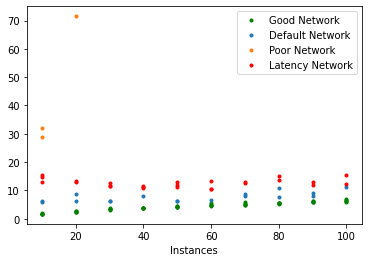

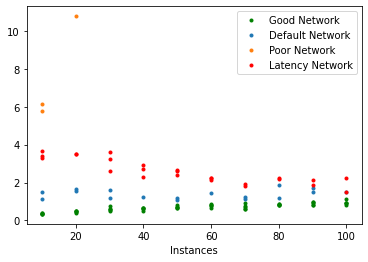

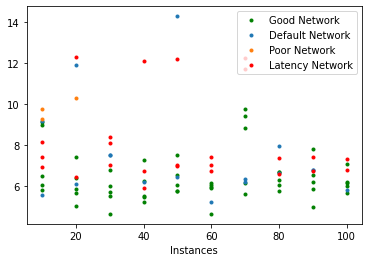

In [127]:
# only stepsize 10
my_data_frame = my_data_frame[my_data_frame['Instances'] % 10 == 0]

# Good Network but 1 Mebibyte Runs
rslt_df1 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 10) & 
    (my_data_frame['SimJitter_ms'] == 0) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 0) &
    (my_data_frame['SimCorrupt_pct'] == 0)
    ]

# Default Network Run
rslt_df2 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 30) & 
    (my_data_frame['SimJitter_ms'] == 5) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 1) &
    (my_data_frame['SimCorrupt_pct'] == 1)
    ]

# Poor Network Run
rslt_df3 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 130) & 
    (my_data_frame['SimJitter_ms'] == 30) &
    (my_data_frame['SimPeerBandwidth_bps'] == 65536) &
    (my_data_frame['SimLoss_pct'] == 2) &
    (my_data_frame['SimCorrupt_pct'] == 2)
    ]

# High latency Network Run
rslt_df4 = my_data_frame[
    (my_data_frame['SimLatency_ms'] == 80) & 
    (my_data_frame['SimJitter_ms'] == 20) &
    (my_data_frame['SimPeerBandwidth_bps'] == 1048576) &
    (my_data_frame['SimLoss_pct'] == 1) &
    (my_data_frame['SimCorrupt_pct'] == 1)
    ]

print("DHT_PUTS") 
p1 = rslt_df1.plot(x='Instances', y='DhtPutDuration_s', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='DhtPutDuration_s', style='.', label='Default Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='DhtPutDuration_s', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='DhtPutDuration_s', style='.', label='Latency Network', color='r')
p4.figure.savefig('DHT_PUTS.pdf')

print("DHT_GETS") 
p1 = rslt_df1.plot(x='Instances', y='DhtQueryDuration_ms', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='DhtQueryDuration_ms', style='.', label='Default Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='DhtQueryDuration_ms', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='DhtQueryDuration_ms', style='.', label='Latency Network', color='r')
p4.figure.savefig('DHT_GETS.pdf')

print("S2CheckDuration")  
p1 = rslt_df1.plot(x='Instances', y='S2CheckDuration_s', style='.',label='Good Network', color='g')
p2 = rslt_df2.plot(ax=p1, x='Instances', y='S2CheckDuration_s', style='.', label='Default Network')
p3 = rslt_df3.plot(ax=p2, x='Instances', y='S2CheckDuration_s', style='.', label='Poor Network')
p4 = rslt_df4.plot(ax=p3, x='Instances', y='S2CheckDuration_s', style='.', label='Latency Network', color='r')
p4.figure.savefig('S2CheckDuration')


<AxesSubplot:xlabel='Instances'>

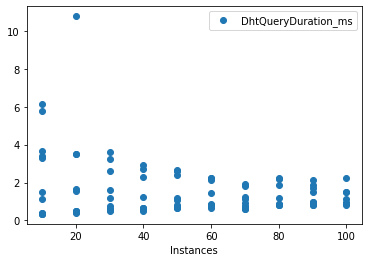

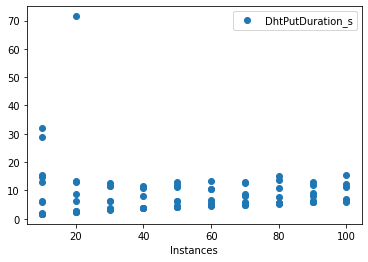

In [128]:



# my_data_frame.plot(x='Instances', y='DhtUploadDuration_s', style='o')
my_data_frame.plot(x='Instances', y='DhtQueryDuration_ms', style='o')


my_data_frame.plot(x='Instances', y='DhtPutDuration_s', style='o')

### Condition Figures from DataFrame

<AxesSubplot:xlabel='Instances'>

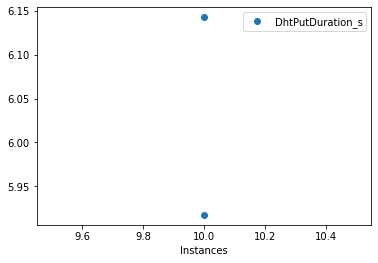

In [129]:
# selecting rows based on 

rslt_df = my_data_frame[(my_data_frame['Instances'] == 10) & (my_data_frame['SimJitter_ms'] == 5)]

rslt_df.plot(x='Instances', y='DhtPutDuration_s', style='o')

### Seaborn Plots

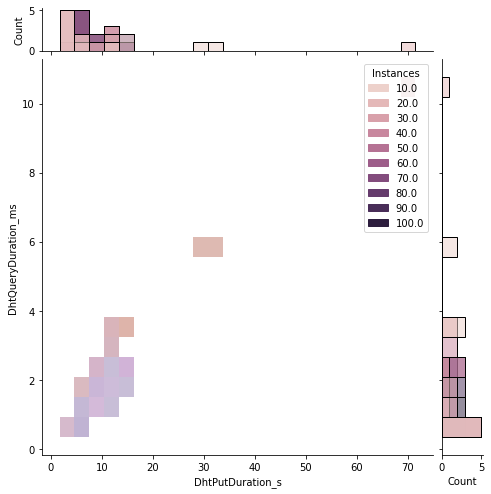

In [130]:
import seaborn as sns

sns.jointplot(data=my_data_frame, x="DhtPutDuration_s", y="DhtQueryDuration_ms", hue="Instances", kind="hist", height=7, ratio=8, marginal_ticks=True)